## IF Notebook for saas data ,
the data was processed and grouped by second,also client lists are taken into consideration.

in this notebook ,we tried applying IF for anomaly detection
we notice a not so good outcome ,as the algorithm is able to detect most of the outliers.



the need for a validation method ,other than the decision function or visual subjective evaluation

In [1]:
import pandas as pd
import pylab as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)warnings.filterwarnings('ignore')
import os

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix

%matplotlib inline

In [2]:
from config import *
#Paths defined in Config file python:

    #Saas Paths
        ##V1
            #raw_saas_v1         csv file containing original saas data V1 (not modified)    
        
            #proc_saas_min_v1    csv file containing processed saas data V1 (grouped by the min)
            #proc_saas_sec_v1    csv file containing processed saas data V1 (grouped by the sec)

        ##V2
            #raw_saas_v2         csv file containing original saas data V2 (not modified)  
                    
            #proc_saas_min_v2    csv file containing processed saas data V2 (grouped by the min)
            #proc_saas_sec_v2    csv file containing processed saas data V2 (grouped by the sec)
        
    #RabbitMQ paths         
        ##V1
            #raw_evts_v1
            
            #min_evts_v1 
            #sec_evts_v1 
            
        ##V2
            #raw_evts_V2  
            
            #min_evts_v2 
            #sec_evts_v2 
            
#function for loading data
def load_data(csv_path):
    return pd.read_csv(csv_path,\
                    parse_dates=['timestamp'] ,index_col=['timestamp'])#comment if timestamp indexing not wanted
                      

#df = load_data(proc_saas_sec_v2 )
df = load_data(sec_evts_v1)

df.head()

,routing_key,headers.name,headers.user_who_performed_action,count
timestamp,,,,
2019-01-28 14:38:49,connection.created,10.238.28.1:38128 -> 10.238.28.5:5672,bus-consolesaas,1
2019-01-28 14:38:50,channel.created,10.238.28.1:38128 -> 10.238.28.5:5672 (1),bus-consolesaas,72
2019-01-28 14:39:13,connection.created,10.238.28.1:38130 -> 10.238.28.5:5672,bus-consolesaas,1
2019-01-28 14:39:14,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (1),bus-consolesaas,2
2019-01-28 14:39:14,channel.created,10.238.28.1:38130 -> 10.238.28.5:5672 (2),bus-consolesaas,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10858 entries, 2019-01-28 14:38:49 to 2020-03-27 16:34:03
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   routing_key                        10858 non-null  object
 1   headers.name                       10858 non-null  object
 2   headers.user_who_performed_action  10858 non-null  object
 3   count                              10858 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 424.1+ KB


### 3*STD function for finding anomaly threshold

In [4]:
# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(random_data):
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    print('DATA MEAN :')
    print(random_data_mean)
    print('  STD : ')
    print( random_data_std)
    
    # Set upper and lower limit to 3 standard deviation
    anomaly_cut_off = random_data_std * 3
    print("")
    print(' Anomaly_cut_off value (aka std * 3 value) ')
    print(anomaly_cut_off)
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    print("")
    print("   LIMIT VALUES  :")
    print('upper_limit value')
    print(upper_limit)
    print('lower_limit value')
    print(lower_limit)
    
    # Find outliers
    anomalies = []
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return upper_limit,anomalies

print("-------------USING THE STANDARD DEVIATION-------------------")
upper_limit , anom = find_anomalies(df['count'])
print("---------------------------------------------")

-------------USING THE STANDARD DEVIATION-------------------
DATA MEAN :
7.53591821698287
  STD : 
47.172885520976116

 Anomaly_cut_off value (aka std * 3 value) 
141.51865656292836

   LIMIT VALUES  :
upper_limit value
149.05457477991123
lower_limit value
-133.98273834594548
---------------------------------------------


In [5]:
#Number of anomaly Cases and Valid cases
anomalies = df[df['count']>= upper_limit]
valid = df[df['count']<upper_limit]

outlier_fraction = len(anomalies)/(len(valid))
print('outlier_fraction')
print(outlier_fraction)


outlier_fraction
0.011269442116047313


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, subplot_titles=('connectgaps = False',
                                                    'connectgaps = True'))
pd.options.mode.chained_assignment = None  # NO WARNING

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV


# Split the dataset in two parts
#train set 80% of data
#test set 20% of data
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)


print('X_train: ' , X_train.shape )
print('X_test : ' , X_test.shape)




X_train:  (8686, 4)
X_test :  (2172, 4)


## IF using a static parameter definition

C:\Users\Syrine.benaziza\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:248: FutureWarning:

'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.



0    8588
1      98
Name: anomaly, dtype: int64


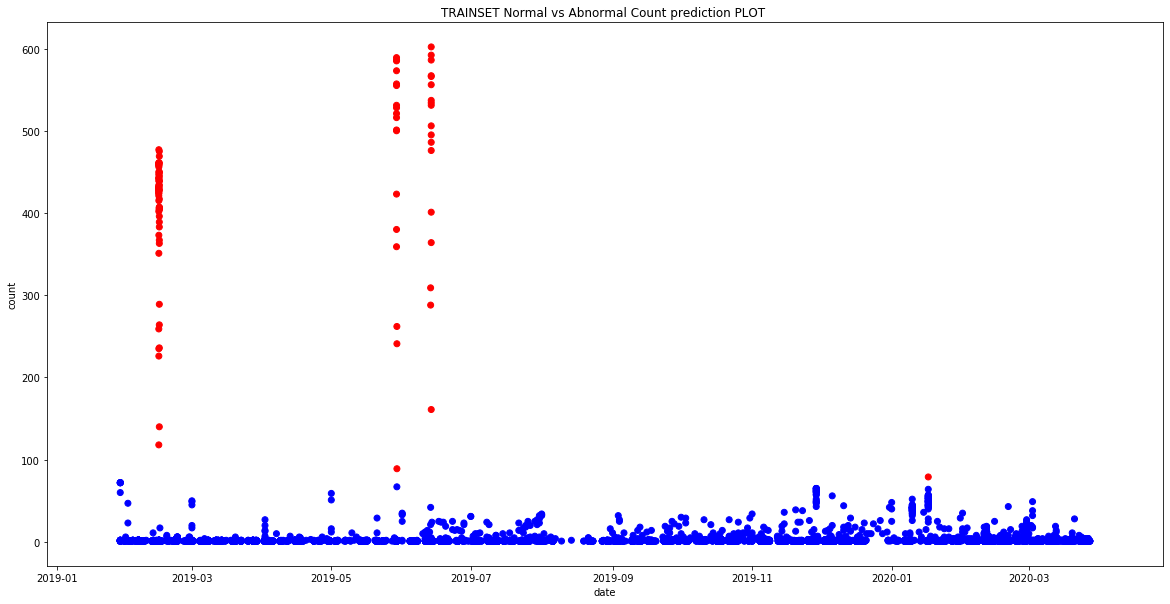

In [7]:

#Isolation Forest implementation with contamination 1%
classifier = IsolationForest(n_estimators=100, max_samples='auto', contamination=outlier_fraction,\
                             bootstrap=False, n_jobs=-1, random_state=42,\
                             verbose=0, behaviour='new')
#the "training part" :finds the coefficients for the coefficients for the equation specified via the algo
classifier.fit(X_train[['count']])

#Average anomaly score of X of the base classifiers.
#The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
#The measure of normality of an observation given a tree is the depth of the leaf containing this observation, 
#which is equivalent to the number of splittings required to isolate this point.
#In case of several observations n_left in the leaf, the average path length of a n_left samples isolation tree 
#is added.

# The Anomaly scores are calclated for each observation and stored in 'scores'
X_train['scores'] = classifier.decision_function(X_train[['count']])

# predict if a given value is an outlier or not; 1=inliner; -1=outlier
X_train['anomaly'] = classifier.predict(X_train[['count']]) 

X_train.loc[X_train['anomaly'] == 1, 'anomaly'] = 0  # if anomaly column value is 1, replace with 0
X_train.loc[X_train['anomaly'] == -1, 'anomaly'] = 1  # if anomaly column value is -1, replace with 1



#Find the index of anomalies 
#here points classified -1 are anomalous
outlier=X_train.loc[X_train['anomaly']==1]
outlier_index=list(outlier.index)

print(X_train['anomaly'].value_counts()) 
# 0(not an anomaly)  and  1(anomaly)

plt.figure(figsize=(20,10))
plt.title('TRAINSET Normal vs Abnormal Count prediction PLOT ')
plt.scatter(x=X_train.index, y=X_train['count'], color=np.where(X_train['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()

0    2145
1      27
Name: anomaly, dtype: int64


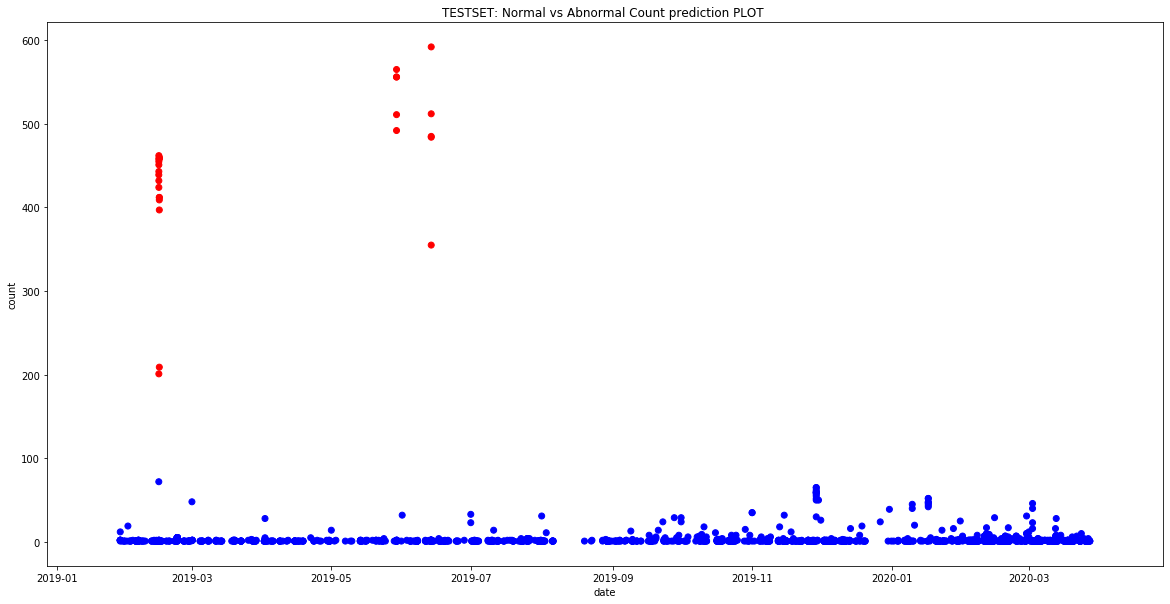

In [8]:
#predictions on the test set
# predict if a given value is an outlier or not; 1=inliner; -1=outlier
#X_test['anomaly'] = classifier.predict(X_test[['count']])

y_pred = classifier.predict(X_test[['count']])
X_test['anomaly']=y_pred

#Find the index of anomalies 
#here points classified -1 are anomalous
outliers=X_test.loc[X_test['anomaly']==-1]
outlier_index=list(outliers.index)

# The Anomaly scores are calclated for each observation and stored in 'scores_pred'
X_test['scores'] = classifier.decision_function(X_test[['count']])
#thelower the score the more abnormal ! (according to documentation)


X_test.loc[X_test['anomaly'] == 1, 'anomaly'] = 0  # if anomaly column value is 1, replace with 0
X_test.loc[X_test['anomaly'] == -1, 'anomaly'] = 1  # if anomaly column value is -1, replace with 1

print(X_test['anomaly'].value_counts()) 
# 0(not an anomaly)  and  1(anomaly)

plt.figure(figsize=(20,10))
plt.title('TESTSET: Normal vs Abnormal Count prediction PLOT ')
plt.scatter(x=X_test.index, y=X_test['count'], color=np.where(X_test['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()



    In Scikit-Learn's IsolationForest the decision_function returns values in the range of [-0.5, 0.5] where -.5 is the most anomalous.
     The documentation for Scikit-Learn's IsolationForest references a paper Isolation-based Anomaly Detection by Liu et al. where equation 2 defines the anomaly score.
    In the paper the anomaly score ranges between 0 and 1, where 1 is most anomalous. 
    In the scores function https://github.com/scikit-learn/scikit-learn/blob/ab93d65/sklearn/ensemble/iforest.py#L267-L272 on line 267 the variable depths.mean(axis=1) corresponds to E(h(x)) and _average_path_length(self.max_samples_)) corresponds to c(psi) in the paper. 
    Thus on line 272 when the function returns 1 minus the score we get the bounds of [-0.5, 0.5].

    Edit/Bonus: The predict method of isolation forest effectively is just comparing the decision_function values to a threshold that is stored in model.threshold_. 
    So after calling the model's predict method on some data the anomalous items are the same items that meet the criteria:
    model.decision_function(data) < model.threshold_.


In [14]:
print('----------------------------------------')
print(' Count of values predicted as Anomalies in the test set')
#
print(anom['count'].value_counts())



----------------------------------------
 Count of values predicted as Anomalies in the test set
3      75
6      30
7      11
8      10
9       7
       ..
565     1
47      1
492     1
44      1
512     1
Name: count, Length: 70, dtype: int64


#### Decision score:
Decision function: Average anomaly score of X of the base classifiers.

The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.

The measure of normality of an observation given a tree is the depth of the leaf containing this observation, 
which is equivalent to the number of splittings required to isolate this point. 
In case of several observations n_left in the leaf, the average path length of a n_left 
samples isolation tree is added.

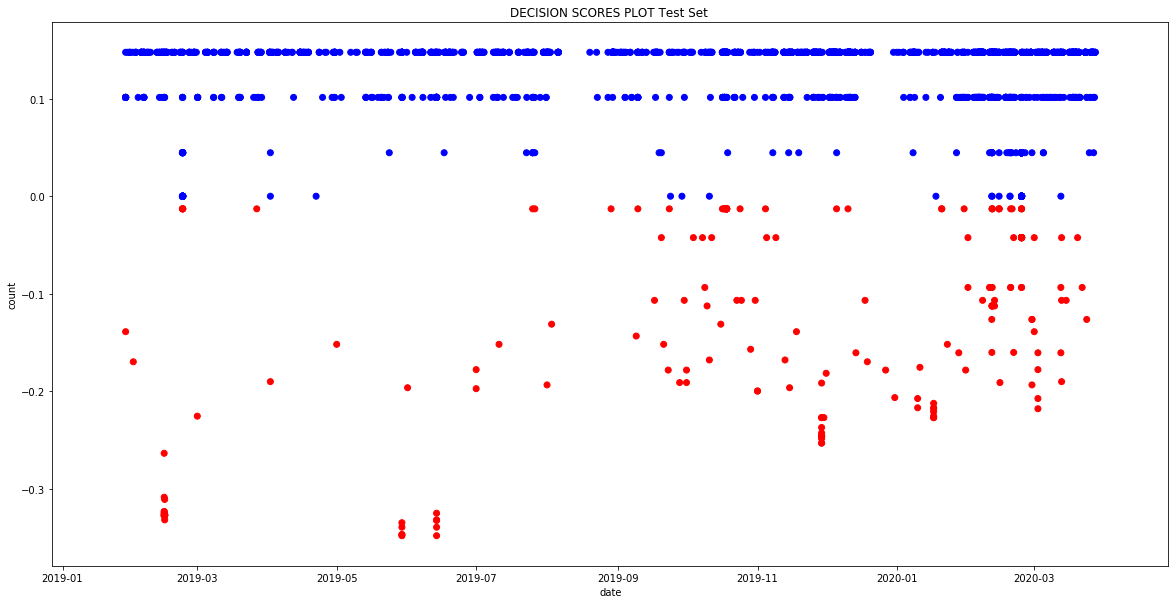

In [15]:
plt.figure(figsize=(20,10))
plt.title('DECISION SCORES PLOT Test Set ')
plt.scatter(x=X_test.index, y=X_test['scores'], color=np.where(X_test['anomaly'] == 1, 'red', 'blue'))#if 1 red , if 0 blue aka noormal
plt.xlabel('date')
plt.ylabel('count')
plt.show()